# Explicit Matrix Factorization 

## ALS

This script plagiarize from [data pique - Explict Matrix Factorization](http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/) you can see original script instead of my own pracitce version. Just enjoy play with Explict MF 

In [2]:
import os,sys

In [3]:
sys.version

'3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]'

In [5]:
import numpy as np 
import pandas as pd 
np.random.seed(0)

In [6]:
cd ml-100k/

z:\DBMTeam\DBM個人資料\Ihong\RS\PlayRecommendSystem\ml-100k


In [11]:
# Load data from disk 
names = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('u.data',sep='\t',names =names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our rating matrix 
ratings = np.zeros((n_users,n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

## split into training ,testing sets
## remove 10 ratings for each users 
## and assign them to the test sets 

def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user,:].nonzero()[0],
                                       size = 10, 
                                       replace = False)
        train[user,test_ratings] = 0.
        test[user,test_ratings] = ratings[user,test_ratings]
        
    # Test and traiining are truely disjoint
    assert(np.all((train*test) == 0 ))
    return train,test

########################################################
train, test = train_test_split(ratings)

In [13]:
train

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [23]:
from sklearn.metrics import mean_squared_error

def get_mse(pred,actual):
    # Ignore non-zero term
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred,actual)

How to use np.linalg.solve ?

`3 x0 + x1 = 9`  and,  `x0 + 2x1 = 8`

```python
  a = np.array([[3,1],[1,2]])
  b = np.array([9,8])
  x = np.linalg.solve(a,b)
```

In [43]:
from numpy.linalg import solve 

class ExplicitMF:
    def __init__(self,
                 ratings,
                n_factors = 40,
                item_reg = 0.0,
                user_reg = 0.0,
                verbose = False):
        """
        Train a matrix factorization model to predict empty entities
        in a matrix. The terminology assume a rating matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding (explicit) ratings 
            
        n_factors : (int)
            Number of latent factors to use in factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whetehr or not print out training progress
        """
        
        self.ratings = ratings 
        self.n_users, self.n_items = ratings.shape 
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose 
        
    def als_step(self,
                latent_vectors, 
                fixed_vecs,
                ratings,
                _lambda,
                type = 'user'):
        """
        one of the two ALS steps, solve for the latent vectors specified by types.
        
        params
        ======
        latent_vectors :
        
        fixed_vecs :
        
        ratings :
        
        _lambda :
        
        type : 'user' or 'item'
        """
        if type == 'user':
            # precompute 
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda
            
            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI),
                                            ratings[u,:].dot(fixed_vecs))
                
        elif type == 'item':
            # precompute 
            
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda 
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI),
                                            ratings[:,i].dot(fixed_vecs))
                
        return latent_vectors
    
    def train(self, n_iter = 10):
        """ Train model for n_iter iteration """
        # Initialize latent vectors 
        
        self.user_vecs = np.random.random((self.n_users, self.n_factors)) ## n * k (user*numbers of latent factors)
        self.item_vecs = np.random.random((self.n_items, self.n_factors)) ## m * k (item*numbers of latent factors)
        
        self.partial_train(n_iter)
        
    def partial_train(self,n_iter):
        """
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        ctr = 1 
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(str(ctr)))
            self.user_vecs = self.als_step(self.user_vecs,
                                           self.item_vecs,
                                           self.ratings,
                                           self.user_reg,
                                           type = 'user')
            self.item_vecs = self.als_step(self.item_vecs,
                                          self.user_vecs,
                                          self.ratings,
                                          self.item_reg,
                                          type = 'item')
            
            ctr += 1
            
    def predict_all(self):
        """ Predict ratings for every user and item """
        predictions = np.zeros((self.user_vecs.shape[0],
                               self.item_vecs.shape[0]))
        
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u,i] = self.predict(u,i)
                
        return predictions
        
    def predict(self,u,i):
        """ Single user and item predictions"""
        # self.user_vecs (user x  k_latent) : x_u.T
        # self.item_vecs (item x k_latent) : y_i.T
        return self.user_vecs[u,:].dot(self.item_vecs[i,:].T) 
    
    def calculate_learning_curve(self,item_array,test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array: (list)
            List of numbers of iterations to train for each step of 
            lerning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item)
        
        The function creates two new attributes:
        -------    
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        
        iter_array.sort()
        self.train_mse = []
        self.test_mse = []
        iter_diff = 0
        for (i,n_iter) in enumerate(iter_array):
            if self._v :
                print('Iteration: {}'.format(n_iter))
            if i == 0 :
                self.train(n_iter - iter_diff)
            else :
                self.partial_train(n_iter - iter_diff)
                
            predictions = self.predict_all()
            
            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter
        

In [44]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0,\
                   verbose = True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)


Iteration: 1
Train mse: 5.37596136475
Test mse: 9.7570309028
Iteration: 2
Train mse: 4.20789502835
Test mse: 8.63358062944
Iteration: 5
Train mse: 3.97156006402
Test mse: 8.5300381224
Iteration: 10
Train mse: 3.93776312282
Test mse: 8.51477087895
Iteration: 25
	current iteration: 10
Train mse: 3.9241474146
Test mse: 8.4904473522
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 3.92316187556
Test mse: 8.48685213455
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 3.92334061587
Test mse: 8.48437783003


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);



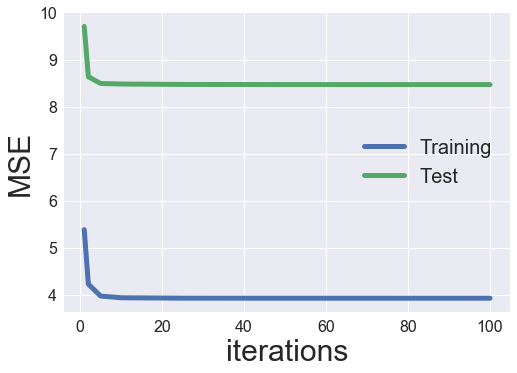

In [39]:
plot_learning_curve(iter_array,MF_ALS)

## Evaluation and Tuning

In [45]:
MF_ALS = ExplicitMF(train,n_factors=40,user_reg=1., item_reg=1.)
iter_array = [1,2,5,10,25,50,100]
MF_ALS.calculate_learning_curve(iter_array,test)

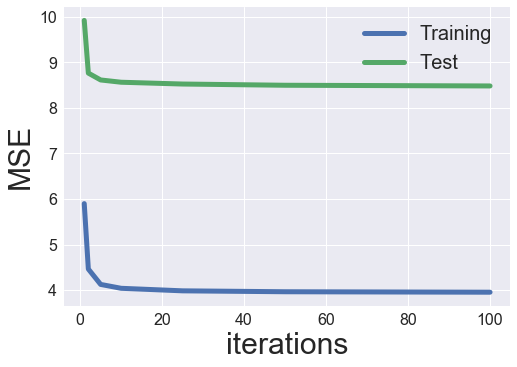

In [48]:
plot_learning_curve(iter_array,MF_ALS)

In [49]:
MF_ALS.train_mse

[5.8988028275701687,
 4.4620201630677876,
 4.1239644248363678,
 4.0386613863099123,
 3.9829347741191561,
 3.9629225770745986,
 3.9527351672500473]

## SGD added

also add bias, 

In [57]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1])) 
                print('Test mse: ' + str(self.test_mse[-1])) 
            iter_diff = n_iter

In [58]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 1.14175832358
Test mse: 1.18843254299
Iteration: 2
Train mse: 1.07193031202
Test mse: 1.13847710557
Iteration: 5
Train mse: 0.975550046998
Test mse: 1.06186699606
Iteration: 10
Train mse: 0.917985926344
Test mse: 1.01136356721
Iteration: 25
	current iteration: 10
Train mse: 0.866215139009
Test mse: 0.963687682815
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.838662577849
Test mse: 0.943136836274
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.752791685735
Test mse: 0.924635849589
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.403444444137
Test mse: 0.917175955653


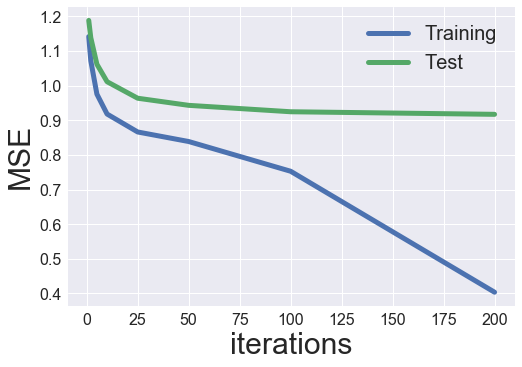

In [59]:
plot_learning_curve(iter_array, MF_SGD)

[1, 2, 5, 10, 25, 50, 100, 200]

## Grid search

# Eye test